In [1]:
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 前処理

In [4]:
#前処理

years=[90,91,92,93,94]
df=pd.DataFrame()
for year in years:
    df_hakone_result=pd.read_csv("./{}_hakone_result.csv".format(year))
    df_10000m=pd.read_csv("./{}_10000m.csv".format(year))
    df_10000m.rename(columns={"大学名":"大学"},inplace=True)
    tmp=df_hakone_result.merge(df_10000m[["大学","タイム"]],on="大学",how="left")
    tmp["大学"].rename(columns=lambda x:"{}_{}".format(year,x),inplace=True)
    df=pd.concat([df,tmp],axis=0)

#タイム欠損行の削除
df=df[~df["タイム"].isnull()]

/home/rmizuta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
#時間のパースその１
totaltime=[]
for record in df["総合記録"].values:
    hour,tmp=record.split("時間")
    minute,tmp=tmp.split("分")
    second=tmp.split("秒")[0]
    totaltime.append(int(hour)*3600+int(minute)*60+int(second))
df["totaltime"]=totaltime    

In [8]:
#時間のパースその２
time_10000m=[]
for record in df["タイム"].values:
    minute,second,microsecond=record.split(":")
    time_10000m.append(int(minute)*60+int(second)+int(microsecond)*0.01)
df["time_10000m"]=time_10000m

In [9]:
#不要行の削除
df=df[df["totaltime"]!=0]

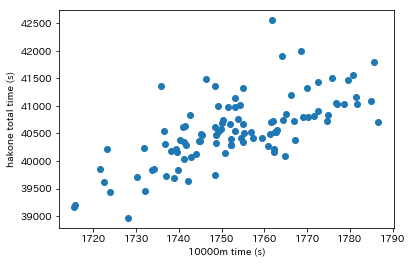

In [11]:
#可視化
plt.scatter(df["time_10000m"],df["totaltime"])
plt.ylabel("hakone total time (s)")
plt.xlabel("10000m time (s)")
plt.show()

# モデリング

In [24]:
import pystan
from pystan import StanModel

# Stanコード
model = """
    data {
        int<lower=0> N;
        real X[N];
        real Y[N];
    }
    parameters {
        real a;
        real<lower=0> sigma;
    }
    model { 
        for (i in 1:N)
            Y[i] ~ normal(a*X[N], sigma);
    }
"""

In [25]:
stan_data = {'N': len(x), 'X':x, 'Y': y}
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=stan_data, iter=10000, chains=3,n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af5e16bf7e40285cc2c7217c0bfa7f07 NOW.


Figure(432x288)


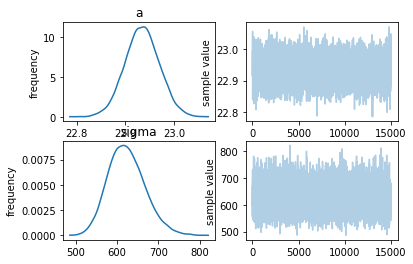

In [26]:
print(fit.plot())

In [28]:
print(fit)

Inference for Stan model: anon_model_af5e16bf7e40285cc2c7217c0bfa7f07.
3 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=15000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      22.93  3.2e-4   0.04  22.87  22.91  22.93  22.96   23.0  12356    1.0
sigma 623.67     0.4  44.36  544.3 592.42 620.91 652.06 719.03  12038    1.0
lp__  -700.2    0.01   0.99 -702.9 -700.6 -699.9 -699.5 -699.2   5897    1.0

Samples were drawn using NUTS at Mon Jan  7 10:03:06 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# 予測

In [ ]:
#今年のデータ読み込み
df2019=pd.read_csv("./10000m_2018.csv")

In [53]:
time_10000m=[]
for record in df2019["タイム"].values:
    minute,second,microsecond=record.split(".")
    time_10000m.append(int(minute)*60+int(second)+int(microsecond)*0.01)
df2019["time_10000m"]=time_10000m
del df2019["タイム"]

In [59]:
import numpy as np
from numpy.random import *

#試行回数
num=10000

#空箱
arr=np.zeros((num,len(time_10000m)))

#各大学の予測タイムを出力
for n in range(num):
    for order, ti in enumerate(time_10000m):
        arr[n,order]=normal(22.93*ti,623.67)
        
#各試行のトップの大学をカウント
prob=pd.DataFrame(pd.Series(arr.argmin(axis=1)).value_counts()/num)

result=df2019.join(prob)
result=result.sort_values(by=0,ascending=False)

In [62]:
result

,大学名,time_10000m,0
0,青学大,1723.93,0.1902
4,東海大,1732.00,0.1256
8,帝京大,1737.72,0.0880
11,駒大,1737.33,0.0869
1,東洋大,1741.09,0.0727
10,順大,1743.80,0.0569
9,中央学大,1747.24,0.0459
16,東京国大,1746.52,0.0457
14,中大,1748.28,0.0448
6,城西大,1748.06,0.0399


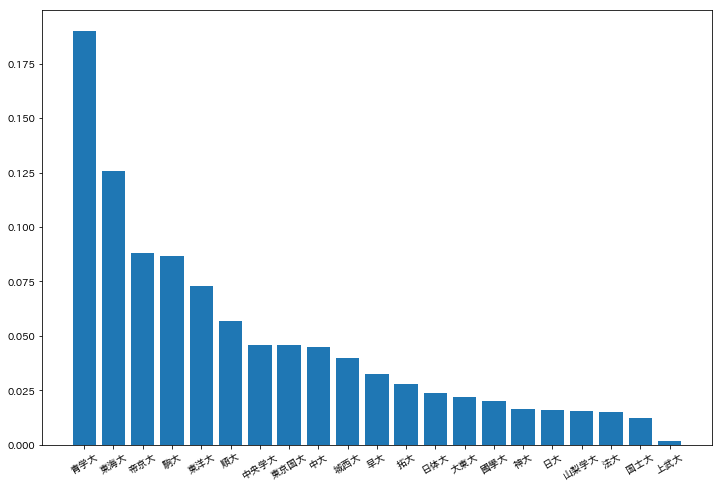

In [63]:
plt.figure(figsize=(12,8))
plt.bar(result["大学名"],result[0])
plt.xticks(rotation=30)
plt.show()